In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings("ignore")

In [56]:
import pathlib
data_directory = pathlib.Path('dataset/asl_alphabet_train');
len(list(data_directory.glob('*/*.jpg')))

87000

In [57]:
import os
folder_names = [name for name in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, name))]


In [58]:
folder_names = sorted(folder_names, key=lambda x: (x[0].islower(), x))
folder_names[:2], folder_names[26:]

(['A', 'B'], ['del', 'nothing', 'space'])

In [59]:
alphabet_images_dict = {
    folder: list(data_directory.glob(f"{folder}/*"))
    for folder in os.listdir(data_directory)
    if(data_directory / folder).is_dir()
}
len(alphabet_images_dict['A']), len(alphabet_images_dict['del'])

(3000, 3000)

In [60]:
alphabet_labels_dict = {
    folder: index for index, folder in enumerate(folder_names)
}
alphabet_labels_dict['A'], alphabet_labels_dict['B'], alphabet_labels_dict['nothing']

(0, 1, 27)

In [61]:
img = cv2.imread(str(alphabet_images_dict['A'][0]))
img.shape

(200, 200, 3)

In [62]:
X = np.zeros((87000, 64, 64, 3), dtype=np.float32)
y = np.zeros(87000, dtype=int)

idx = 0
for alphabet, images in alphabet_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(64, 64))
        X[idx] = resized_img
        y[idx] = alphabet_labels_dict[alphabet]
        idx += 1

In [63]:
X_scaled = X / 255

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=0)

In [65]:
num_classes = 29

# Model Definition
model = Sequential([
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes)
])


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

def add_noise(image):
    noise = np.random.normal(loc=0, scale=0.05, size=image.shape)
    noisy_image = np.clip(image + noise, 0, 1)
    return noisy_image

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    preprocessing_function=add_noise,
    shear_range=0.1,
    horizontal_flip=False
)

# Train the Model
model.fit(
    datagen.flow(X_train, y_train, batch_size=32),  
    epochs=39,
    steps_per_epoch=len(X_train) // 32  # Ensures one full pass over the dataset per epoch
)


Epoch 1/39
2310/2310 ━━━━━━━━━━━━━━━━━━━━ 288s 122ms/step - accuracy: 0.3600 - loss: 2.1283
Epoch 2/39
2310/2310 ━━━━━━━━━━━━━━━━━━━━ 0s 10us/step - accuracy: 0.8750 - loss: 0.3567   
Epoch 3/39
2310/2310 ━━━━━━━━━━━━━━━━━━━━ 278s 120ms/step - accuracy: 0.8553 - loss: 0.4340
Epoch 4/39
2310/2310 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step - accuracy: 0.9062 - loss: 0.5153    
Epoch 5/39
2310/2310 ━━━━━━━━━━━━━━━━━━━━ 278s 121ms/step - accuracy: 0.9095 - loss: 0.2722
Epoch 6/39
2310/2310 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step - accuracy: 0.9688 - loss: 0.1095    
Epoch 7/39
2310/2310 ━━━━━━━━━━━━━━━━━━━━ 280s 121ms/step - accuracy: 0.9338 - loss: 0.1984
Epoch 8/39
2310/2310 ━━━━━━━━━━━━━━━━━━━━ 0s 7us/step - accuracy: 0.9688 - loss: 0.0845    
Epoch 9/39
2310/2310 ━━━━━━━━━━━━━━━━━━━━ 281s 122ms/step - accuracy: 0.9467 - loss: 0.1647
Epoch 10/39
2310/2310 ━━━━━━━━━━━━━━━━━━━━ 0s 7us/step - accuracy: 0.9688 - loss: 0.0780    
Epoch 11/39
2310/2310 ━━━━━━━━━━━━━━━━━━━━ 277s 120ms/step - accuracy: 0.9521 -

In [66]:
model.evaluate(X_test, y_test)

408/408 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9963 - loss: 0.0108


[0.008713945746421814, 0.9972413778305054]

In [67]:
X_test.shape, X_train.shape

((13050, 64, 64, 3), (73950, 64, 64, 3))

In [68]:
predictions = model.predict(X_test)

408/408 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step


408/408 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step


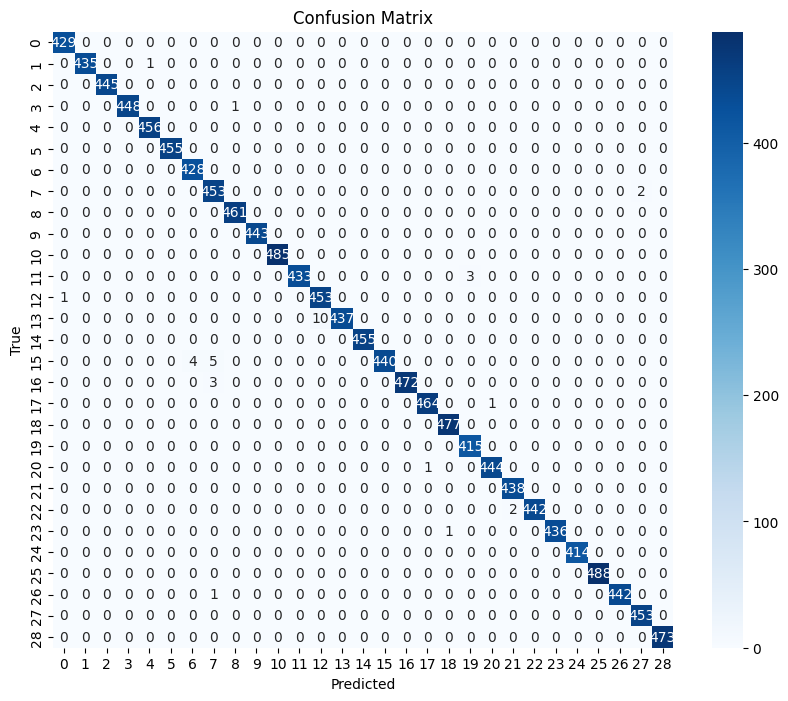

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00       429\n           1       1.00      1.00      1.00       436\n           2       1.00      1.00      1.00       445\n           3       1.00      1.00      1.00       449\n           4       1.00      1.00      1.00       456\n           5       1.00      1.00      1.00       455\n           6       0.99      1.00      1.00       428\n           7       0.98      1.00      0.99       455\n           8       1.00      1.00      1.00       461\n           9       1.00      1.00      1.00       443\n          10       1.00      1.00      1.00       485\n          11       1.00      0.99      1.00       436\n          12       0.98      1.00      0.99       454\n          13       1.00      0.98      0.99       447\n          14       1.00      1.00      1.00       455\n          15       1.00      0.98      0.99       449\n          16       1.00      0.99      1.00       475\n       

In [69]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

classification_report(y_test, y_pred)


In [70]:
y_pred = np.argmax(model.predict(X_test), axis=1)


408/408 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step


In [71]:
y_pred[:15], y_test[:15]

(array([22,  4, 14, 10, 13,  2, 11, 26, 26, 10,  6,  7, 20, 20, 25],
       dtype=int64),
 array([22,  4, 14, 10, 13,  2, 11, 26, 26, 10,  6,  7, 20, 20, 25]))

In [72]:
test_directory = pathlib.Path('dataset/asl_alphabet_test');
len(list(test_directory.glob('*/*.jpg')))

29

In [73]:
jpg_files = [str(file) for file in test_directory.glob('*/*.jpg')]
jpg_files

['dataset\\asl_alphabet_test\\test\\A_test.jpg',
 'dataset\\asl_alphabet_test\\test\\B_test.jpg',
 'dataset\\asl_alphabet_test\\test\\C_test.jpg',
 'dataset\\asl_alphabet_test\\test\\del_test.jpg',
 'dataset\\asl_alphabet_test\\test\\D_test.jpg',
 'dataset\\asl_alphabet_test\\test\\E_test.jpg',
 'dataset\\asl_alphabet_test\\test\\F_test.jpg',
 'dataset\\asl_alphabet_test\\test\\G_test.jpg',
 'dataset\\asl_alphabet_test\\test\\H_test.jpg',
 'dataset\\asl_alphabet_test\\test\\I_test.jpg',
 'dataset\\asl_alphabet_test\\test\\J_test.jpg',
 'dataset\\asl_alphabet_test\\test\\K_test.jpg',
 'dataset\\asl_alphabet_test\\test\\L_test.jpg',
 'dataset\\asl_alphabet_test\\test\\M_test.jpg',
 'dataset\\asl_alphabet_test\\test\\nothing_test.jpg',
 'dataset\\asl_alphabet_test\\test\\N_test.jpg',
 'dataset\\asl_alphabet_test\\test\\O_test.jpg',
 'dataset\\asl_alphabet_test\\test\\P_test.jpg',
 'dataset\\asl_alphabet_test\\test\\Q_test.jpg',
 'dataset\\asl_alphabet_test\\test\\R_test.jpg',
 'dataset\\a

In [74]:
predictions_dict = {}
for i in jpg_files:
    img = cv2.imread(i)
    resized_img = cv2.resize(img,(64,64))
    scaled_img = resized_img.astype(np.float32) / 255.0
    scaled_img = np.expand_dims(scaled_img, axis=0)
    pred = np.argmax(model.predict(scaled_img))
    predictions_dict[i] = pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

In [75]:
predictions_dict

{'dataset\\asl_alphabet_test\\test\\A_test.jpg': 0,
 'dataset\\asl_alphabet_test\\test\\B_test.jpg': 1,
 'dataset\\asl_alphabet_test\\test\\C_test.jpg': 2,
 'dataset\\asl_alphabet_test\\test\\del_test.jpg': 26,
 'dataset\\asl_alphabet_test\\test\\D_test.jpg': 3,
 'dataset\\asl_alphabet_test\\test\\E_test.jpg': 4,
 'dataset\\asl_alphabet_test\\test\\F_test.jpg': 5,
 'dataset\\asl_alphabet_test\\test\\G_test.jpg': 6,
 'dataset\\asl_alphabet_test\\test\\H_test.jpg': 7,
 'dataset\\asl_alphabet_test\\test\\I_test.jpg': 8,
 'dataset\\asl_alphabet_test\\test\\J_test.jpg': 9,
 'dataset\\asl_alphabet_test\\test\\K_test.jpg': 10,
 'dataset\\asl_alphabet_test\\test\\L_test.jpg': 11,
 'dataset\\asl_alphabet_test\\test\\M_test.jpg': 12,
 'dataset\\asl_alphabet_test\\test\\nothing_test.jpg': 27,
 'dataset\\asl_alphabet_test\\test\\N_test.jpg': 13,
 'dataset\\asl_alphabet_test\\test\\O_test.jpg': 14,
 'dataset\\asl_alphabet_test\\test\\P_test.jpg': 15,
 'dataset\\asl_alphabet_test\\test\\Q_test.jpg':

In [76]:
for key, value in predictions_dict.items():
    for alpha, label in alphabet_labels_dict.items():
        if value == label:
            predictions_dict[key] = alpha

In [77]:
predictions_dict

{'dataset\\asl_alphabet_test\\test\\A_test.jpg': 'A',
 'dataset\\asl_alphabet_test\\test\\B_test.jpg': 'B',
 'dataset\\asl_alphabet_test\\test\\C_test.jpg': 'C',
 'dataset\\asl_alphabet_test\\test\\del_test.jpg': 'del',
 'dataset\\asl_alphabet_test\\test\\D_test.jpg': 'D',
 'dataset\\asl_alphabet_test\\test\\E_test.jpg': 'E',
 'dataset\\asl_alphabet_test\\test\\F_test.jpg': 'F',
 'dataset\\asl_alphabet_test\\test\\G_test.jpg': 'G',
 'dataset\\asl_alphabet_test\\test\\H_test.jpg': 'H',
 'dataset\\asl_alphabet_test\\test\\I_test.jpg': 'I',
 'dataset\\asl_alphabet_test\\test\\J_test.jpg': 'J',
 'dataset\\asl_alphabet_test\\test\\K_test.jpg': 'K',
 'dataset\\asl_alphabet_test\\test\\L_test.jpg': 'L',
 'dataset\\asl_alphabet_test\\test\\M_test.jpg': 'M',
 'dataset\\asl_alphabet_test\\test\\nothing_test.jpg': 'nothing',
 'dataset\\asl_alphabet_test\\test\\N_test.jpg': 'N',
 'dataset\\asl_alphabet_test\\test\\O_test.jpg': 'O',
 'dataset\\asl_alphabet_test\\test\\P_test.jpg': 'P',
 'dataset\\a

In [78]:
model.save('SignLanguageRecognition.keras')